In [1]:
import pickle
import os
import numpy as np
from utils import Fold, Gestures
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:

def load_pickle(basepath, name):
    save_path = os.path.join(basepath, name)

    with open(save_path, 'rb') as file:
        dictionary = pickle.load(file)
        return dictionary

def display_results(data: dict):
    for model_type in data:
        print("%s results using %d iterations:" % (model_type, data.get(model_type).get('iterations')))
        sorted_folds = list(data.get(model_type).get('folds').keys())
        sorted_folds.sort(key=lambda x: x.value)
        for fold in sorted_folds:
            print("\t%d-fold results:" % fold.value)
            fold_results = data.get(model_type).get('folds').get(fold)

            acc_per_fold = np.array(list(map(lambda x: x['acc_per_fold'], fold_results)))
            loss_per_fold = np.array(list(map(lambda x: x['loss_per_fold'], fold_results)))
            print("\t\tIndividual accuracies:")
            for acc in acc_per_fold:
                print("\t\t%.3f" % acc.mean(), end='')
            acc_per_fold = acc_per_fold.flatten()
            loss_per_fold = loss_per_fold.flatten()
            print("\n\t\tOverall acc: %.2f Std: %.2f" % (acc_per_fold.mean(), acc_per_fold.std()))
            print("\t\tOverall loss: %.2f" % loss_per_fold.mean())


def draw_conf_matrix(confusions, base_path: str, name: str):
    reshaped = confusions.reshape(confusions.shape[0] * confusions.shape[1], 10, 10)

    overall_confusion = np.zeros((reshaped.shape[1], reshaped.shape[2]))
    for conf in reshaped:
        overall_confusion = np.add(overall_confusion, conf)

    # Normalize predictions
    normalized_confusion = overall_confusion / overall_confusion.sum(axis=1, keepdims=1)
    normalized_confusion = normalized_confusion.round(decimals=2)

    save_path = os.path.join(base_path, f"{name.replace(' ', '_')}.svg")
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    ConfusionMatrixDisplay(normalized_confusion, display_labels=Gestures).plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(name)
    plt.savefig(save_path, bbox_inches="tight")

    plt.show()

In [3]:
# Analyze accuracies
conv_lstm = load_pickle('../results', 'conv_lstm.pickle')
display_results(conv_lstm)

ConvLSTM 64 results using 3 iterations:
	10-fold results:
		Individual accuracies:
		59.212		61.804		59.699
		Overall acc: 60.24 Std: 6.02
		Overall loss: 13.27


In [4]:
# Analyze accuracies
lstm = load_pickle('../results', 'lstm.pickle')
display_results(lstm)

LSTM 16 results using 3 iterations:
	5-fold results:
		Individual accuracies:
		63.532		63.013		64.605
		Overall acc: 63.72 Std: 2.98
		Overall loss: 1.71
	10-fold results:
		Individual accuracies:
		66.443		65.470		65.227
		Overall acc: 65.71 Std: 5.47
		Overall loss: 1.50
LSTM 32 results using 3 iterations:
	5-fold results:
		Individual accuracies:
		65.961		62.909		64.555
		Overall acc: 64.47 Std: 4.24
		Overall loss: 2.40
	10-fold results:
		Individual accuracies:
		66.528		66.098		66.334
		Overall acc: 66.32 Std: 5.53
		Overall loss: 2.19
LSTM 64 results using 3 iterations:
	5-fold results:
		Individual accuracies:
		66.716		64.577		65.503
		Overall acc: 65.60 Std: 3.18
		Overall loss: 2.78
	10-fold results:
		Individual accuracies:
		66.975		67.066		67.880
		Overall acc: 67.31 Std: 4.92
		Overall loss: 2.52
LSTM 128 results using 3 iterations:
	5-fold results:
		Individual accuracies:
		66.766		66.618		66.644
		Overall acc: 66.68 Std: 3.73
		Overall loss: 2.55
	10-fold results:
	

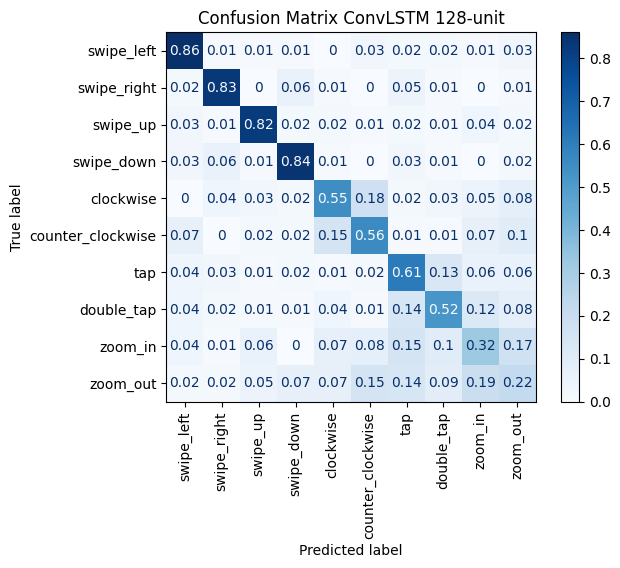

In [6]:
conv_lstm = load_pickle('../results', 'conv_lstm.pickle')
fold_ten = conv_lstm.get('ConvLSTM 64').get('folds').get(Fold.TEN)

confusions = np.array(list(map(lambda x: x['confusion_per_fold'], fold_ten)))
draw_conf_matrix(confusions, '../results/figs/', "Confusion Matrix ConvLSTM 128-unit")

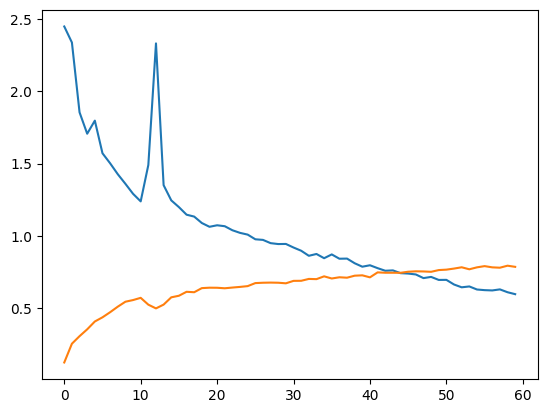

In [35]:
history = list(map(lambda x: x['history_per_fold'], fold_ten))
single_loss = history[0][0].history['loss']
single_acc = history[0][0].history['acc']

plt.plot(single_loss)
plt.plot(single_acc)

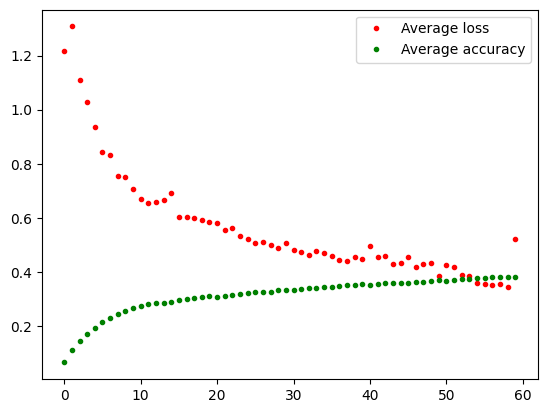

In [43]:
loss = []
acc = []

for h_array in history:
    for h in h_array:
        loss.append(h.history['loss'])
        acc.append(h.history['acc'])

loss = np.array(loss)
acc = np.array(acc)

dim = loss.shape[1]
avg_loss = np.zeros(dim)
avg_acc = np.zeros(dim)
for l in loss:
    avg_loss += l

for a in acc:
    avg_acc += a

plt.plot(avg_loss / dim, 'r.', label='Average loss')
plt.plot(avg_acc / dim, 'g.', label='Average accuracy')
plt.legend()
plt.show()

In [ ]:
# Analyze file sizes
base = '../models'
for model in os.listdir(base):
    print(model)
    path = os.path.join(base, model)
    tflite_size = os.path.getsize(os.path.join(path, f"{model}.tflite"))
    tflite_quantized_size = os.path.getsize(os.path.join(path, f"{model}_quantized.tflite"))
    print("\tNormal size: %d bytes (%.1f Kb)\n\tQuantized size: %d bytes (%.1f Kb)" % (tflite_size, round(float(tflite_size / 1000), 1), tflite_quantized_size, round(float(tflite_quantized_size / 1000), 1)))